In [24]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import re
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
import pickle
import tweepy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

In [25]:
rf_df = pd.read_csv('data/full/rf_preproc_train.csv')

In [26]:
rf_df = rf_df[['user_id', 'avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'fake_words_score', 'favourites_count', 'followers_count', 'freq',
       'friends_count', 'genuine_words_score', 'listed_count', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_fav', 'min_hash',
       'min_len', 'min_ret', 'porn_words_score',
       'profile_use_background_image', 'prop_words_score', 'quote_perc',
       'ret_perc', 'spam_words_score', 'statuses_count',
       'tweet_intradistance', 'url', 'url_intradistance', 'url_perc',
       'description_len', 'name_len', 'screen_name_len', 'age','target', 'nsfw_avg', 'nsfw_profile']]

In [27]:
X_train, X_val, y_train, y_val = train_test_split(rf_df.drop(columns=['target']), rf_df['target'], test_size=0.2)

In [28]:
rf = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=None)

In [29]:
cv = cross_validate(rf, X_train.drop(columns=['user_id']), y_train, cv=10, scoring='f1_macro')

In [30]:
cv['test_score'].mean()

0.9636522544071255

In [31]:
rf.fit(X_train.drop(columns=['user_id']), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
rf_pred = rf.predict_proba(X_val.drop(columns=['user_id']))

In [32]:
rf.predict_proba(X_val.drop(columns=['user_id']).iloc[0:10])

array([[0.096, 0.008, 0.032, 0.752, 0.112],
       [0.556, 0.   , 0.   , 0.016, 0.428],
       [1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.016, 0.616, 0.256, 0.008, 0.104],
       [0.04 , 0.   , 0.008, 0.   , 0.952],
       [0.   , 0.212, 0.016, 0.   , 0.772],
       [0.   , 0.   , 1.   , 0.   , 0.   ],
       [0.736, 0.124, 0.008, 0.052, 0.08 ],
       [0.464, 0.   , 0.016, 0.008, 0.512],
       [1.   , 0.   , 0.   , 0.   , 0.   ]])

In [34]:
rf_prob = pd.DataFrame(rf_pred, columns=['rf_0', 'rf_1', 'rf_2', 'rf_3', 'rf_4'])

In [35]:
X_val.reset_index(inplace=True, drop=True)

In [36]:
rf_prob.reset_index(inplace=True, drop=True)

In [37]:
y_val.reset_index(inplace=True, drop=True)

In [38]:
rf_prob['user_id'] = X_val['user_id']

In [39]:
rf_prob['target'] = y_val

In [40]:
rf_prob.head()

,rf_0,rf_1,rf_2,rf_3,rf_4,user_id,target
0,0.096,0.008,0.032,0.752,0.112,40010436,3
1,0.556,0.000,0.000,0.016,0.428,2924491016,4
2,1.000,0.000,0.000,0.000,0.000,554624040,0
3,0.016,0.616,0.256,0.008,0.104,1912522274,1
4,0.040,0.000,0.008,0.000,0.952,20114963,4


## BotOrNot

In [41]:
model = pickle.load(open("../scripts/bot_or_not.model", "rb"))

In [42]:
X_val.drop(columns=['porn_words_score', 'prop_words_score', 'spam_words_score', 'fake_words_score', 'genuine_words_score'], inplace=True)

In [43]:
y_bon = y_val

In [44]:
y_bon[:13]

0     3
1     4
2     0
3     1
4     4
5     1
6     2
7     0
8     4
9     0
10    1
11    0
12    4
Name: target, dtype: int64

In [45]:
y_bon[y_bon != 4] = 1
y_bon[y_bon == 4] = 0

In [46]:
X_val.drop(columns=['nsfw_profile', 'nsfw_avg'], inplace=True)
X_train.drop(columns=['nsfw_profile', 'nsfw_avg'], inplace=True)

In [47]:
bon_pred = model.predict_proba(X_val.drop(columns=['user_id']))

In [48]:
bon_pred

array([[0.348, 0.652],
       [0.736, 0.264],
       [0.46 , 0.54 ],
       ...,
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.02 , 0.98 ]])

In [49]:
bon_prob = pd.DataFrame(bon_pred, columns=['bon_4', 'bon_3'])

bon_prob['bon_3'] = bon_pred.astype(int)

bon_prob['bon_4'] = np.logical_not(bon_pred).astype(int)

In [50]:
bon_prob['bon_0'] = 0
bon_prob['bon_1'] = 0
bon_prob['bon_2'] = 0

In [51]:
y_pred = model.predict(X_val.drop(columns=['user_id']))

In [52]:
print(pd.crosstab(y_bon, y_pred , rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target  0.0   1.0
Actual Target              
0                 733    10
1                 265  4014


In [53]:
bon_prob['bon_0'] = bon_prob['bon_3']/4
bon_prob['bon_1'] = bon_prob['bon_3']/4
bon_prob['bon_2'] = bon_prob['bon_3']/4
bon_prob['bon_3'] = bon_prob['bon_3']/4

In [54]:
X_val.reset_index(inplace=True, drop=True)

In [55]:
bon_prob.reset_index(inplace=True, drop=True)

In [56]:
bon_prob['user_id'] = X_val['user_id']

In [57]:
bon_prob['target'] = rf_prob['target']

In [58]:
bon_prob = bon_prob.reindex(columns=['bon_0', 'bon_1', 'bon_2', 'bon_3', 'bon_4', 'user_id', 'target'])

In [59]:
users = pd.read_csv('data/full/train.csv')

In [60]:
users = users[['user_id','target']]

In [61]:
tweets = pd.concat([pd.read_csv('data/propaganda/tweets.csv', sep='\t')[['user_id','full_text']], \
          pd.read_csv('data/porn/tweets.csv', sep='\t')[['user_id','full_text']], \
          pd.read_csv('data/spam/tweets.csv', sep='\t')[['user_id','full_text']], \
          pd.read_csv('data/fake_followers/tweets.csv', sep='\t')[['user_id','full_text']], \
          pd.read_csv('data/genuine/tweets.csv', sep='\t')[['user_id','full_text']]])

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,4,8,11,18,19,20,23,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
 

In [62]:
tweets = tweets.drop_duplicates()

In [63]:
tweets = pd.merge(tweets, users, on='user_id')

In [64]:
mask = np.in1d(tweets.user_id, X_train.user_id)

In [65]:
val_mask = np.in1d(tweets.user_id, X_val.user_id)

In [66]:
nb_train = tweets[mask]

In [67]:
nb_val = tweets[val_mask]

In [68]:
def remove_rt(x):
    if 'RT @' in x:
        try:
            return x[x.find(':')+2:]
        except:
            return x
    else:
        return x

In [69]:
stop_words = stopwords.words('english')

def remove_stop(x):
    return [word for word in x.split() if word not in stop_words]

In [70]:
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: remove_rt(x))
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: x.lower())
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: remove_stop(x))
nb_train['full_text'] = nb_train['full_text'].astype(str)
nb_train = nb_train[nb_train['full_text']!='[]']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [71]:
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: remove_rt(x))
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: x.lower())
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: remove_stop(x))
nb_val['full_text'] = nb_val['full_text'].astype(str)
nb_val = nb_val[nb_val['full_text']!='[]']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [72]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc:(stemmer.stem(w) for w in analyzer(doc))


stem_vectorizer = StemmedCountVectorizer(stemmer)

pipeline = Pipeline([('vect', stem_vectorizer), 
                     ('tfidf', TfidfTransformer()), 
                     ('mnb', MultinomialNB(fit_prior=False))])

clf = pipeline.fit(nb_train['full_text'], nb_train['target'])

In [73]:
predictions = []
i = 0

for usr in X_val['user_id']:
    
    i+=1
    clear_output()
    print(i)
    tweets_list = nb_val[nb_val.user_id == usr]['full_text']
    tweets_list = tweets_list[tweets_list.notnull()]
    if len(tweets_list[tweets_list.notnull()]) != 0:
        pred = clf.predict_proba(tweets_list)
        predictions.append(np.mean(pred, axis=0))
    else:
        predictions.append(np.array([0.2,0.2,0.2,0.2,0.2]))

5022


In [74]:
prob = pd.DataFrame(predictions, columns=['nb_0', 'nb_1', 'nb_2', 'nb_3', 'nb_4'])

In [75]:
prob['target'] = rf_prob['target']

In [76]:
prob['user_id'] = X_val['user_id']

In [77]:
# prob.to_csv('data/full/predictions1.csv')

In [78]:
stack_df = rf_prob.merge(prob, on=['user_id' , 'target'])

In [79]:
stack_df = stack_df.merge(bon_prob, on=['user_id' , 'target'])

In [80]:
stack_df = stack_df.reindex_axis(sorted(stack_df.columns), axis=1)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


In [81]:
stack_df.head()

,bon_0,bon_1,bon_2,bon_3,bon_4,nb_0,nb_1,nb_2,nb_3,nb_4,rf_0,rf_1,rf_2,rf_3,rf_4,target,user_id
0,0.163,0.163,0.163,0.163,0.348,0.182387,0.213074,0.297444,0.036951,0.270144,0.096,0.008,0.032,0.752,0.112,3,40010436
1,0.066,0.066,0.066,0.066,0.736,0.200000,0.200000,0.200000,0.200000,0.200000,0.556,0.000,0.000,0.016,0.428,4,2924491016
2,0.135,0.135,0.135,0.135,0.460,0.200000,0.200000,0.200000,0.200000,0.200000,1.000,0.000,0.000,0.000,0.000,0,554624040
3,0.208,0.208,0.208,0.208,0.168,0.144943,0.338079,0.170696,0.033190,0.313092,0.016,0.616,0.256,0.008,0.104,1,1912522274
4,0.007,0.007,0.007,0.007,0.972,0.200000,0.200000,0.200000,0.200000,0.200000,0.040,0.000,0.008,0.000,0.952,4,20114963


In [82]:
stack_df.to_csv('data/full/logreg_train.csv')

In [2]:
stack_df = pd.read_csv('data/full/logreg_train.csv')

In [3]:
stack_df.head()

,Unnamed: 0,bon_0,bon_1,bon_2,bon_3,bon_4,nb_0,nb_1,nb_2,nb_3,nb_4,rf_0,rf_1,rf_2,rf_3,rf_4,target,user_id
0,0,0.247143,0.247143,0.247143,0.247143,0.011429,0.137270,0.164383,0.372618,0.031418,0.294311,0.0,0.0,1.000,0.000,0.0,2,55274536
1,1,0.250000,0.250000,0.250000,0.250000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.0,0.0,0.000,1.000,0.0,3,1176249991
2,2,0.250000,0.250000,0.250000,0.250000,0.000000,0.068502,0.086353,0.683575,0.020640,0.140930,0.0,0.0,1.000,0.000,0.0,2,2358040098
3,3,0.250000,0.250000,0.250000,0.250000,0.000000,0.062542,0.098308,0.679081,0.013714,0.146355,0.0,0.0,0.996,0.004,0.0,2,2373412087
4,4,0.237143,0.237143,0.237143,0.237143,0.051429,0.007484,0.043665,0.927185,0.000709,0.020956,0.0,0.0,1.000,0.000,0.0,2,2580235808


## Metamodel LogReg training

In [84]:
X = stack_df.drop(columns=['user_id', 'target'])
y = stack_df['target']

In [369]:
def grid_eval(X, y, params):
    
    grid = GridSearchCV(LogisticRegression(), params, cv=10, scoring='f1_macro')
    grid.fit(X, y)
    
    return pd.DataFrame(grid.cv_results_)

In [376]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, filename):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
    
    
    best_index = np.argmax(cv_results['mean_test_score'])
    best_param = cv_results.loc[best_index]['param_max_iter']
    best_score = cv_results['mean_test_score'].max()
    min_score = cv_results['mean_test_score'].min()
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    #ax.plot([best_param, ] * 2, [min_score, best_score],
        #    linestyle='-.', color='black', marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    #ax.annotate("%0.3f" % best_score,
        #        (best_param+5, best_score + 0.00005), size=16)

    ax.set_title("Grid Search Scores", fontsize=24)
    ax.set_xlabel(name_param_1, fontsize=24)
    ax.set_ylabel('F1 Macro Score', fontsize=24)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    fig.savefig('data/full/'+ filename +'.png')

## Default LR

In [395]:
params = {'max_iter': [1,5,10,100,1000], 'penalty': ['l1'], 'solver':['liblinear','saga']}

In [397]:
max_iter = [1,5,10,100,1000]
solver = ['liblinear', 'saga']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


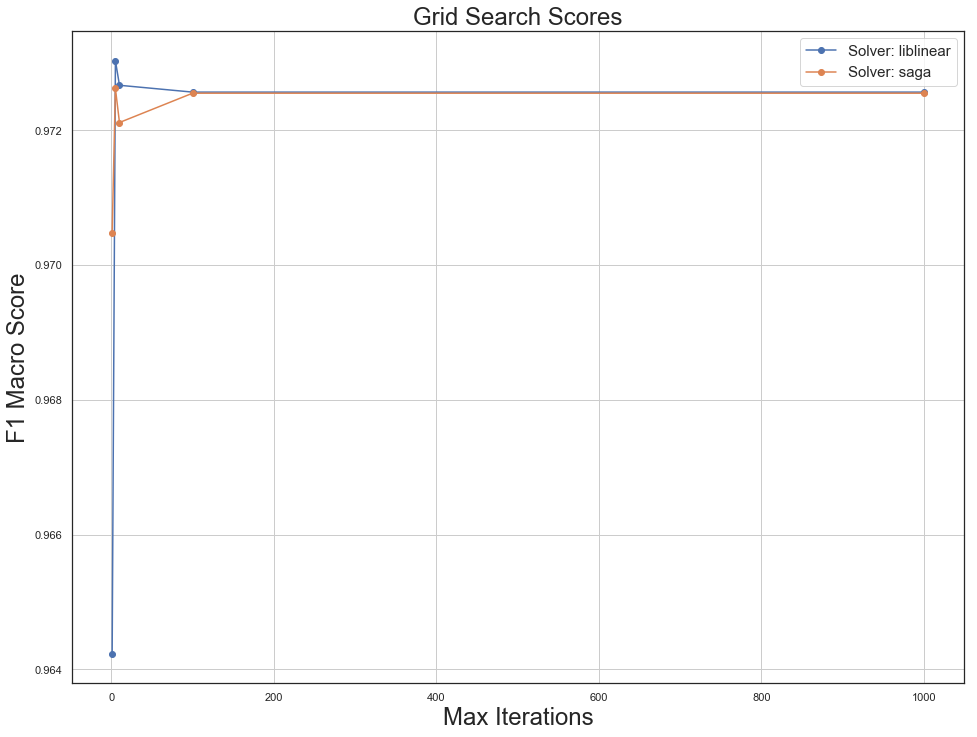

In [398]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'logreg_default')

## Default RF

In [412]:
params = {'n_estimators': [10,100,200,300,500,1000], 'max_features': ['sqrt', 'log2']}

In [413]:
n_estimators = [10,100,200,300,500,1000]
max_features = ['sqrt', 'log2']

In [414]:
results = grid_eval_rf(X, y, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


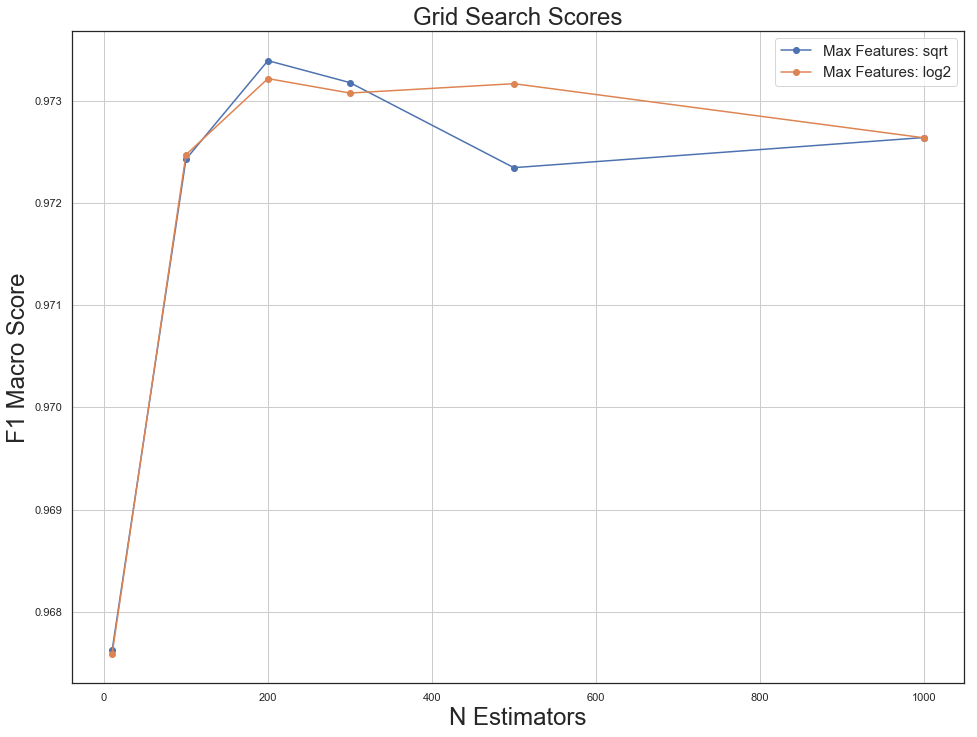

In [416]:
plot_grid_search_rf(results, n_estimators, max_features, 'N Estimators', 'Max Features', 'random_forest_default')

## L2 - Lambda

In [339]:
params = {'penalty':['l2'], 'C': [0.01, 0.1, 1, 10],'class_weight': ['balanced'], 'max_iter': [3,5,10,20,30,50,75], 'multi_class': ['auto'], 'solver': ['sag']}

In [341]:
max_iter = [3,5,10,20,30,50,75]
C = [0.01, 0.1, 1, 10]

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


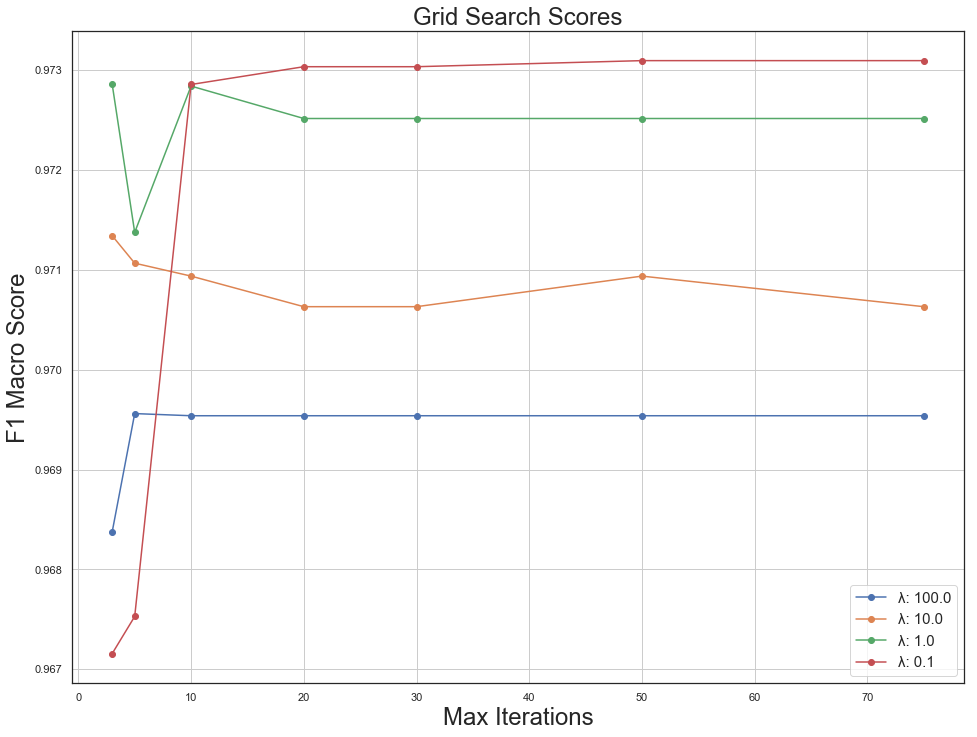

In [342]:
plot_grid_search(results.sort_values(by=['param_C', 'param_max_iter']), max_iter, C, 'Max Iterations', 'λ', 'logreg_l2_lambda')

## L1 - Lambda

In [343]:
params = {'penalty':['l1'], 'C': [0.01, 0.1, 1, 10],'class_weight': ['balanced'], 'max_iter': [3,5,10,20,30,50,75], 'multi_class': ['auto'], 'solver': ['saga']}

In [345]:
max_iter = [3,5,10,20,30,50,75]
C = [0.01, 0.1, 1, 10]

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


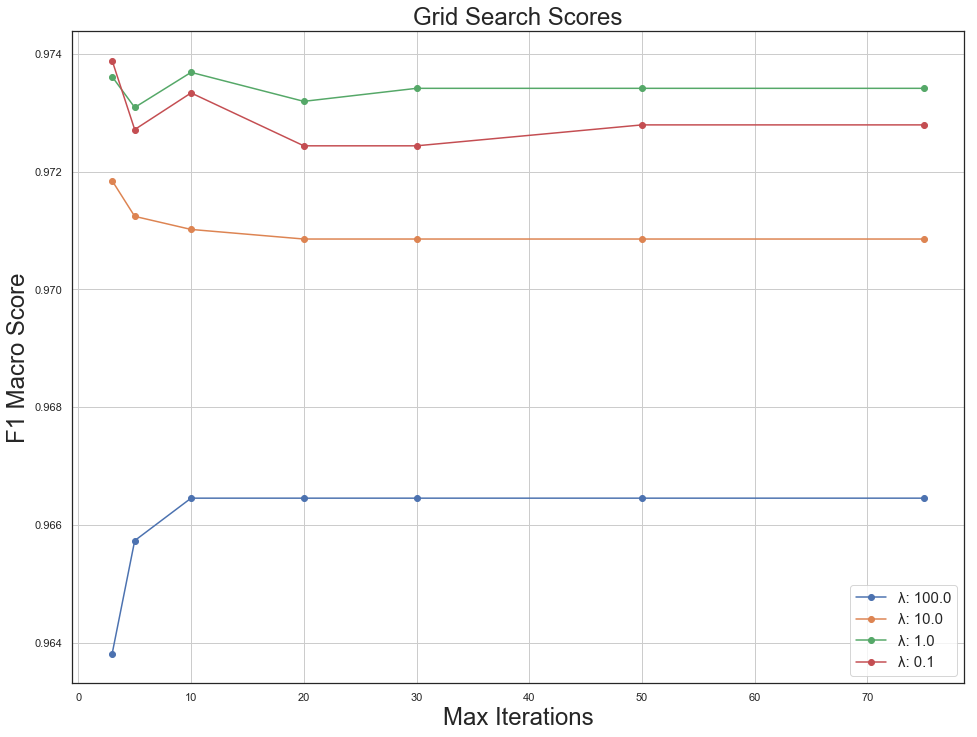

In [346]:
plot_grid_search(results.sort_values(by=['param_C', 'param_max_iter']), max_iter, C, 'Max Iterations', 'λ', 'logreg_l1_lambda')

## L2 - Close

In [299]:
params = {'class_weight': ['balanced'], 'max_iter': [3,5,10,20,30,50,75], 'multi_class': ['auto'], 'solver': ['newton-cg', 'lbfgs', 'sag']}

In [220]:
max_iter = [3,5,10,20,30,50,75]
solver = ['newton-cg', 'lbfgs', 'sag']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


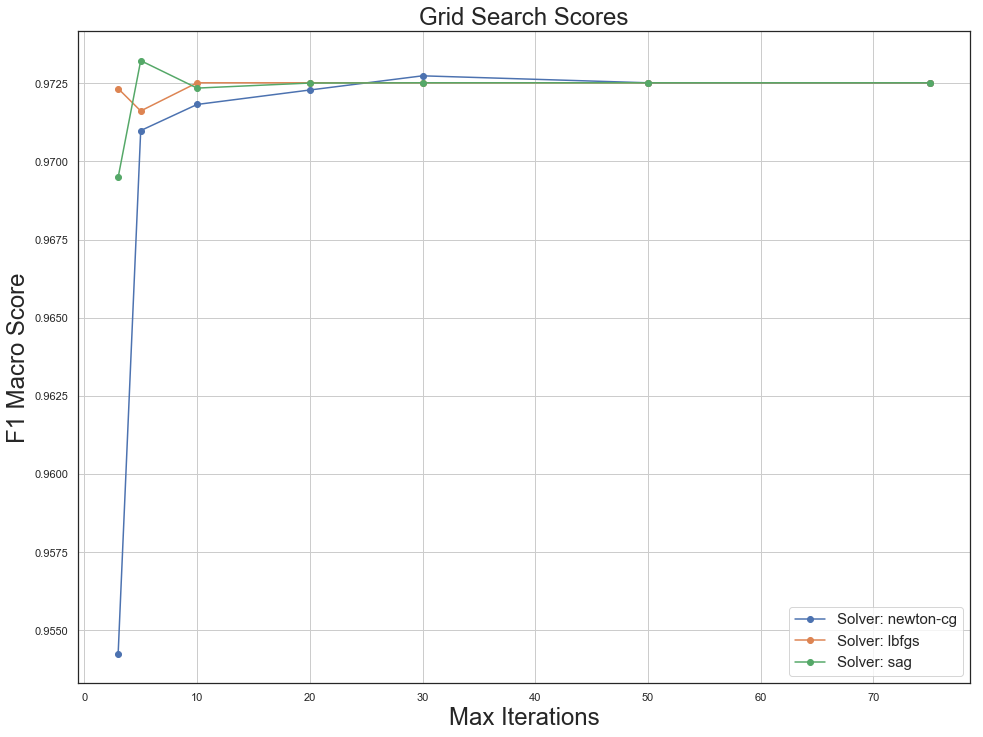

In [221]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'logreg_l2_close')

## L2 - Far

In [222]:
params = {'class_weight': ['balanced'], 'max_iter': [100,500,2000,5000], 'multi_class': ['auto'], 'solver': ['newton-cg', 'lbfgs', 'sag']}

In [223]:
max_iter = [100,500,2000,5000]
solver = ['newton-cg', 'lbfgs', 'sag']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


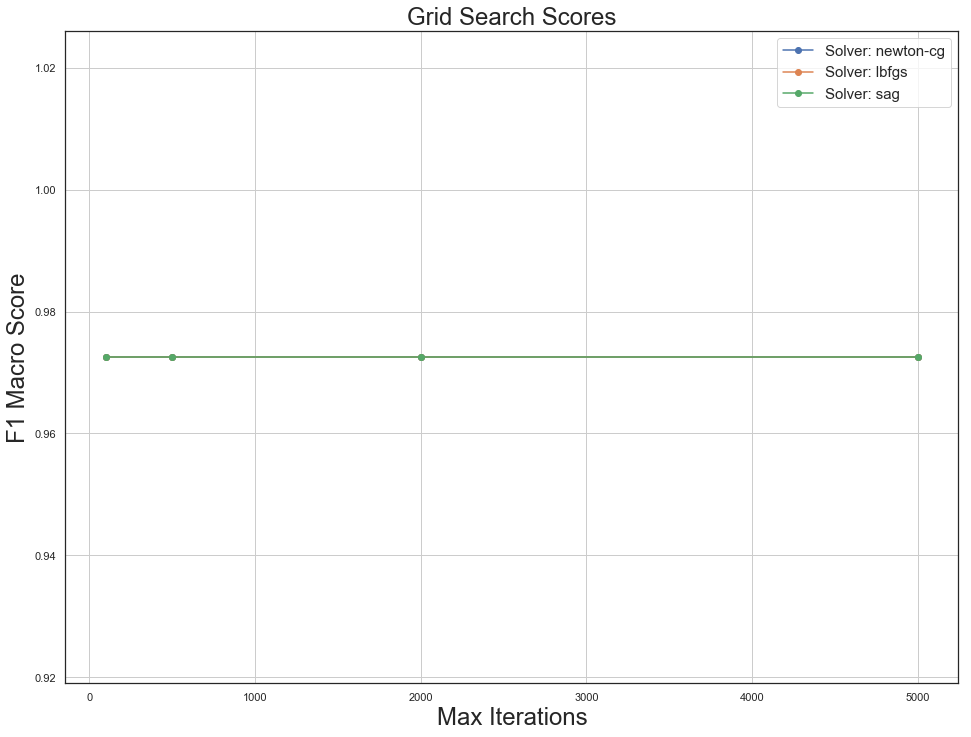

In [225]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'logreg_l2_far')

## L1 - Close

In [371]:
params = {'penalty': ['l1'],'class_weight': ['balanced'], 'max_iter': [3,5,10,20,30,50,75,150], 'multi_class': ['auto'], 'solver': ['saga', 'liblinear']}

In [372]:
X = stack_df.drop(columns=['user_id', 'target'])
y = stack_df['target']

In [381]:
results.sort_values(by=['param_solver', 'param_max_iter'])[['param_solver','mean_test_score']]

,param_solver,mean_test_score
1,liblinear,0.970751
3,liblinear,0.972739
5,liblinear,0.973279
7,liblinear,0.972422
9,liblinear,0.972645
11,liblinear,0.972422
13,liblinear,0.972645
15,liblinear,0.972645
0,saga,0.971636
2,saga,0.973780


In [382]:
max_iter = [3,5,10,20,30,50,75,150]
solver = ['liblinear','saga']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


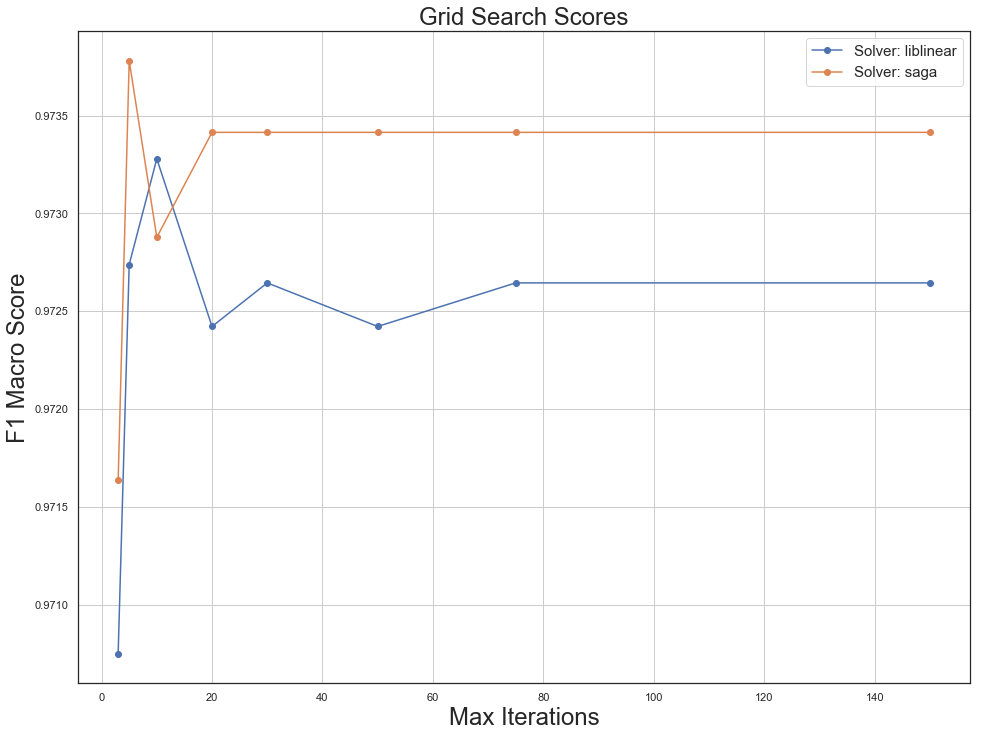

In [383]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'logreg_l1_close')

## L1 - Far

In [384]:
params = {'penalty':['l1'], 'class_weight': ['balanced'], 'max_iter': [100,500,2000,5000], 'multi_class': ['auto'], 'solver': ['liblinear','saga']}

In [385]:
max_iter = [100,500,2000,5000]
solver = ['liblinear','saga']

In [386]:
results = grid_eval(X, y, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


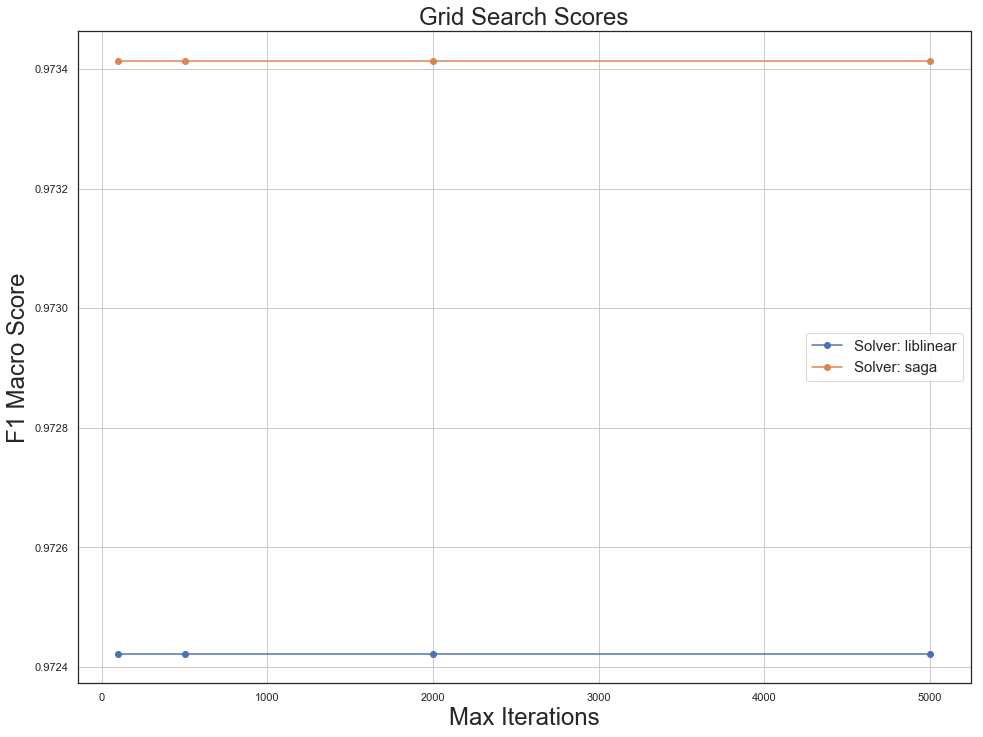

In [387]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'logreg_l1_far')

In [198]:
z = lr.predict_proba(stack_df.drop(columns=['user_id', 'target']).iloc[1:2])

In [199]:
pickle.dump( lr, open( "../scripts/models/lr.model", "wb" ) )

## Metamodel RanFor training

In [271]:
def grid_eval_rf(X, y, params):
    
    grid = GridSearchCV(RandomForestClassifier(), params, cv=10, scoring='f1_macro')
    grid.fit(X, y)
    
    return pd.DataFrame(grid.cv_results_)

In [277]:
def plot_grid_search_rf(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, filename):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
    
    
    best_index = np.argmax(cv_results['mean_test_score'])
    best_param = cv_results.loc[best_index]['param_n_estimators']
    best_score = cv_results['mean_test_score'].max()
    min_score = cv_results['mean_test_score'].min()
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    #ax.plot([best_param, ] * 2, [min_score, best_score],
        #    linestyle='-.', color='black', marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    #ax.annotate("%0.3f" % best_score,
        #        (best_param+5, best_score + 0.00005), size=16)

    ax.set_title("Grid Search Scores", fontsize=24)
    ax.set_xlabel(name_param_1, fontsize=24)
    ax.set_ylabel('F1 Macro Score', fontsize=24)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    fig.savefig('data/full/'+ filename +'.png')

## Gini

In [287]:
params = {'criterion': ['gini'], 'n_estimators': [10,20,50,100,150,200,250,300], 'max_depth': [None,24,26,28]}

In [288]:
X = stack_df.drop(columns=['user_id', 'target'])
y = stack_df['target']

In [289]:
results = grid_eval_rf(X, y, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/

In [290]:
n_estimators = [10,20,50,100,150,200,250,300]
max_depth = [None,24,26,28]

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


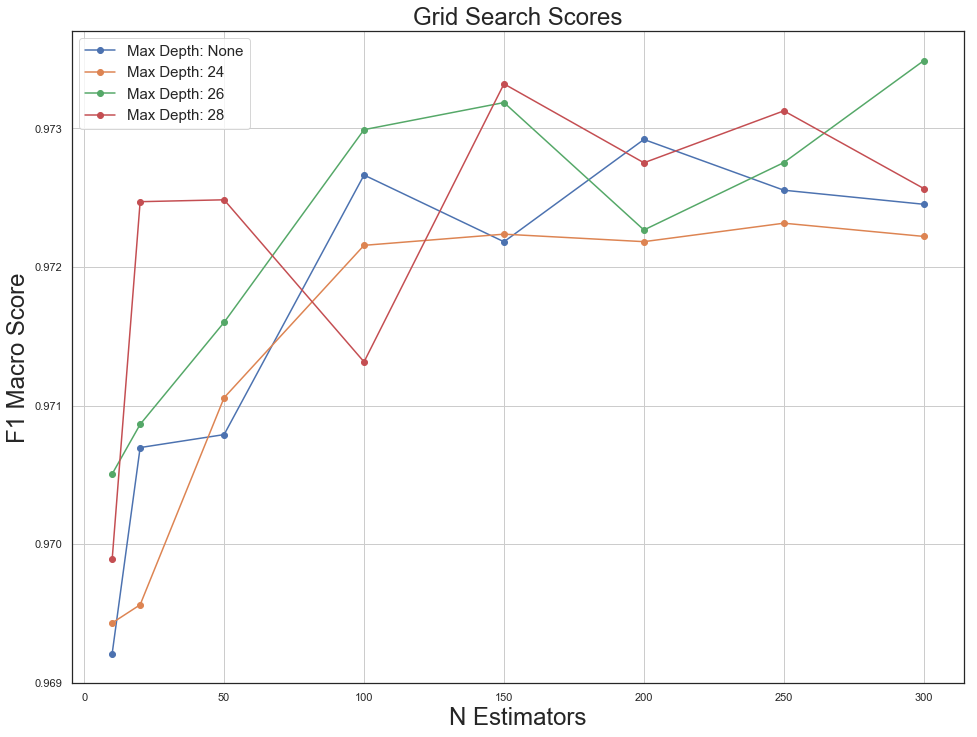

In [291]:
plot_grid_search_rf(results, n_estimators, max_depth, 'N Estimators', 'Max Depth', 'random_forest_gini_stacking')

## Entropy

In [292]:
params = {'criterion': ['entropy'], 'n_estimators': [10,20,50,100,150,200,250,300], 'max_depth': [None,24,26,28]}

In [293]:
X = stack_df.drop(columns=['user_id', 'target'])
y = stack_df['target']

In [294]:
results = grid_eval_rf(X, y, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/

In [295]:
n_estimators = [10,20,50,100,150,200,250,300]
max_depth = [None,24,26,28]

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


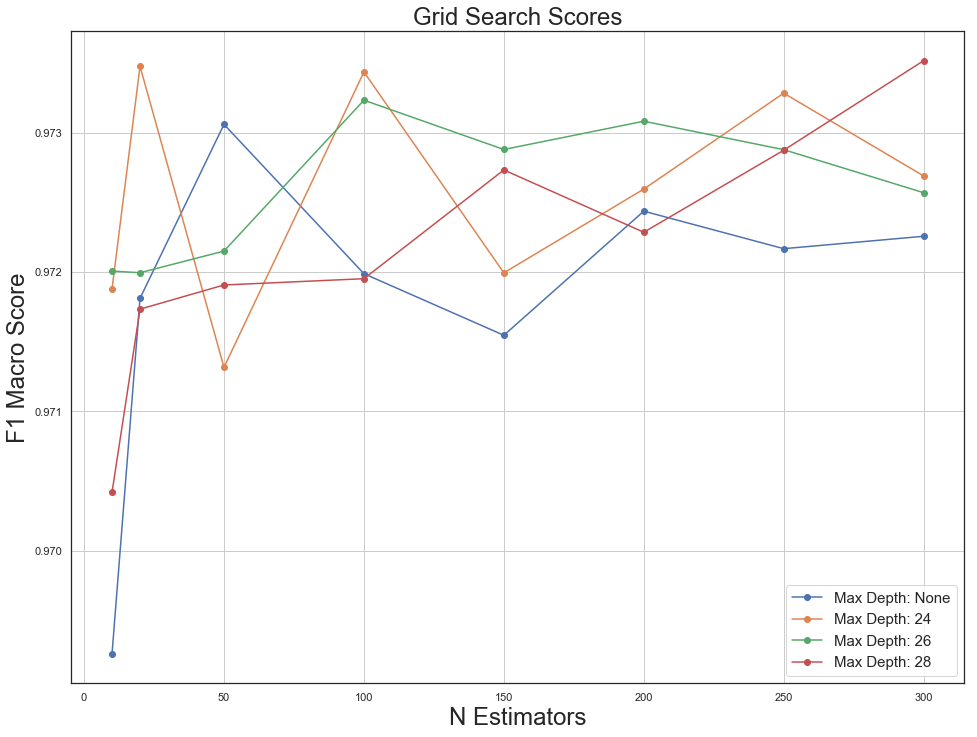

In [296]:
plot_grid_search_rf(results, n_estimators, max_depth, 'N Estimators', 'Max Depth', 'random_forest_entropy_stacking')

In [454]:
rf = RandomForestClassifier(n_estimators=1000)
lr = LogisticRegression(penalty="l1", solver="saga", max_iter=100, multi_class="auto")

In [419]:
import time

In [428]:
start = time.time()
rf.fit(X,y)
end = time.time()
print("Fitting time: " + str(end - start))

Fitting time: 5.494039058685303


In [426]:
start = time.time()
lr.fit(X,y)
end = time.time()
print("Fitting time: " + str(end - start))

Fitting time: 0.1631028652191162


In [ ]:
rf.fit(X,y)

In [ ]:
lr.fit(X,y)

In [430]:
start = time.time()
lr.predict_proba(np.array(X.iloc[0]).reshape(1, -1))
end = time.time()
print("Prediction time: " + str(end - start))

Prediction time: 0.0006127357482910156


In [465]:
cv = cross_validate(lr, X, y, cv=10, scoring=["f1_macro", "precision_macro", 'recall_macro'])

In [466]:
cv['test_precision_macro'].mean()

0.972372002035295

In [467]:
cv['test_f1_macro'].mean()

0.9734135096435935

In [468]:
cv['test_recall_macro'].mean()

0.9748395771670119

In [91]:
lr = LogisticRegression(class_weight="balanced", penalty="l1", C=1, solver="saga", max_iter=100, multi_class="multinomial")

In [92]:
lr.fit(X,y)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

In [93]:
pickle.dump(lr, open("../scripts/lr.model", "wb"))